## 1.1.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

In [2]:
N_NODES = 500          
K_NEIGHBORS = 4        
BETA = 0.3             
RHO = 0.7              
WEEKS = 15             
N_SIMULATIONS = 100    
INITIAL_INFECTED = 10  


SUSCEPTIBLE = 0
INFECTED = 1
RECOVERED = 2

In [3]:
def create_k_regular_graph(n, k):
    """
    Crea la matrice di adiacenza per un grafo k-regolare simmetrico 
    dove ogni nodo è connesso ai k vicini più prossimi (modulo n).
    """
    rows = []
    cols = []
    
    # Per ogni nodo i, i vicini sono i ± 1, i ± 2 ... fino a k/2
    half_k = k // 2
    
    for i in range(n):
        for offset in range(1, half_k + 1):
            # Vicino a destra (i + offset)
            neighbor_r = (i + offset) % n
            rows.append(i)
            cols.append(neighbor_r)
            
            # Vicino a sinistra (i - offset)
            neighbor_l = (i - offset) % n
            rows.append(i)
            cols.append(neighbor_l)
            
    # Creiamo una matrice sparsa (CSR) per efficienza
    data = np.ones(len(rows))
    adj_matrix = sparse.csr_matrix((data, (rows, cols)), shape=(n, n))
    return adj_matrix

In [ ]:
def run_simulation(adj_matrix, n_nodes, weeks, beta, rho):
    """
    Esegue una singola simulazione dell'epidemia.
    Restituisce la storia dei conteggi S, I, R e i nuovi infetti per settimana.
    """
    # Inizializzazione stati: tutti suscettibili (0)
    states = np.zeros(n_nodes, dtype=int)
    
    # Scelta casuale dei primi 10 infetti
    initial_indices = np.random.choice(n_nodes, INITIAL_INFECTED, replace=False)
    states[initial_indices] = INFECTED
    
    # Array per salvare i dati storici
    # Indice 0 = stato iniziale, indici 1..15 = settimane
    history_S = np.zeros(weeks + 1)
    history_I = np.zeros(weeks + 1)
    history_R = np.zeros(weeks + 1)
    new_infections_hist = np.zeros(weeks + 1) # nuovi casi per ogni step
    
    # Registra stato iniziale (t=0)
    history_S[0] = np.sum(states == SUSCEPTIBLE)
    history_I[0] = np.sum(states == INFECTED)
    history_R[0] = np.sum(states == RECOVERED)
    new_infections_hist[0] = INITIAL_INFECTED # All'inizio sono "nuovi" per definizione o 0, qui contiamo i 10 iniziali
    
    for t in range(weeks):
        # 1. Identifica nodi infetti correnti
        infected_mask = (states == INFECTED)
        
        # 2. Calcola m (numero di vicini infetti per ogni nodo)
        # Il prodotto matrice-vettore conta quanti vicini '1' ha ciascun nodo
        m = adj_matrix.dot(infected_mask.astype(int))
        
        # --- Transizione S -> I ---
        # Probabilità che un nodo i venga infettato: 1 - (1 - beta)^m
        prob_infection = 1 - (1 - beta) ** m
        
        # Genera numeri casuali per tutti i nodi
        random_vals = np.random.rand(n_nodes)
        
        # Diventano infetti SE sono Suscettibili AND random < probabilità
        newly_infected_mask = (states == SUSCEPTIBLE) & (random_vals < prob_infection)
        
        # --- Transizione I -> R ---
        # Probabilità rho costante
        random_vals_rec = np.random.rand(n_nodes)
        newly_recovered_mask = (states == INFECTED) & (random_vals_rec < rho)
        
        # --- Aggiornamento Stati (Sincrono) ---
        states[newly_infected_mask] = INFECTED
        states[newly_recovered_mask] = RECOVERED
        
        # Registra dati
        count_S = np.sum(states == SUSCEPTIBLE)
        count_I = np.sum(states == INFECTED)
        count_R = np.sum(states == RECOVERED)
        count_New_I = np.sum(newly_infected_mask)
        
        history_S[t+1] = count_S
        history_I[t+1] = count_I
        history_R[t+1] = count_R
        new_infections_hist[t+1] = count_New_I
        
    return history_S, history_I, history_R, new_infections_hist

Esecuzione di 100 simulazioni su grafo con 500 nodi...


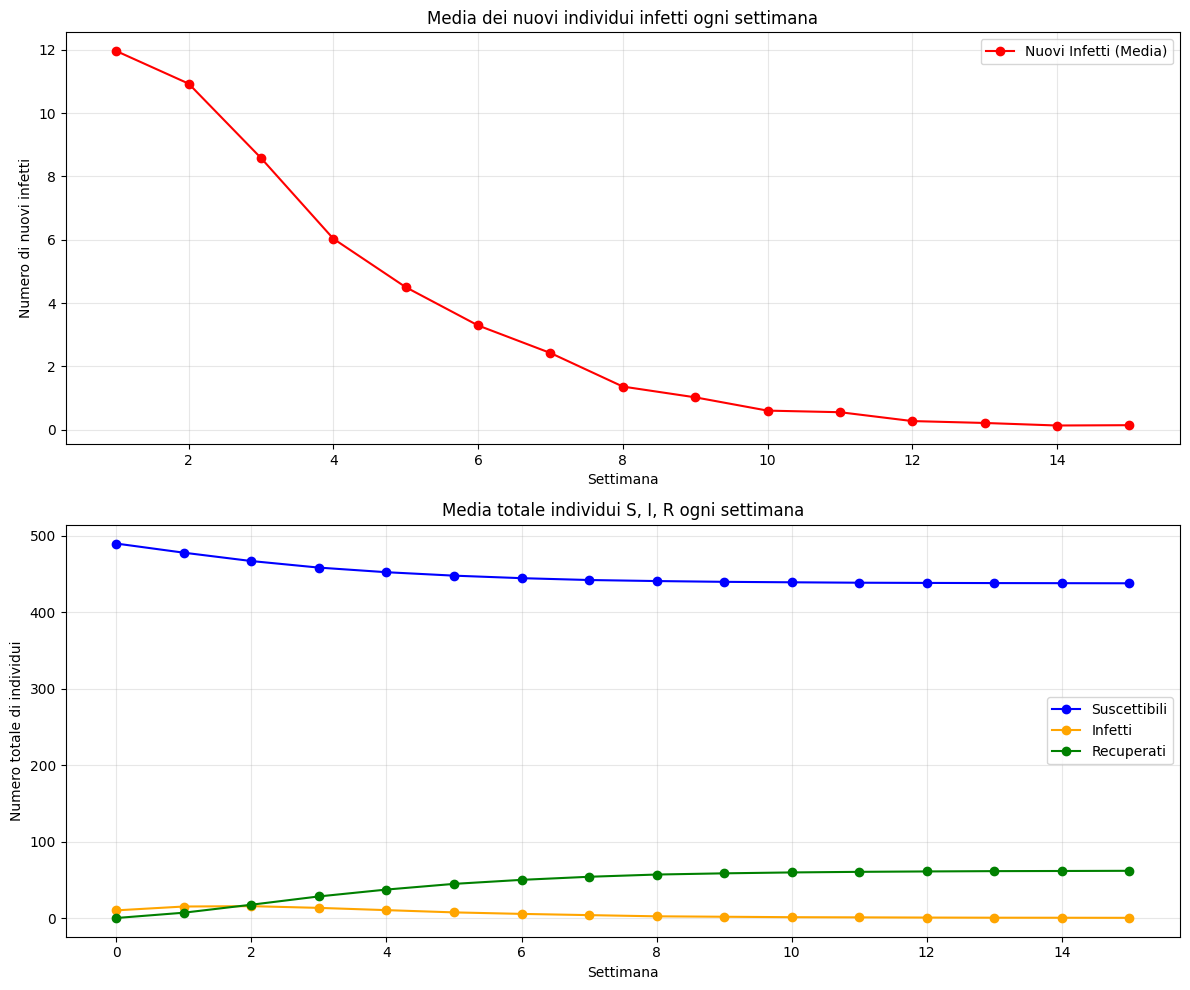

In [5]:
adj_matrix = create_k_regular_graph(N_NODES, K_NEIGHBORS)

# Accumulatori per le medie
total_S = np.zeros(WEEKS + 1)
total_I = np.zeros(WEEKS + 1)
total_R = np.zeros(WEEKS + 1)
total_new_I = np.zeros(WEEKS + 1)

print(f"Esecuzione di {N_SIMULATIONS} simulazioni su grafo con {N_NODES} nodi...")

for sim in range(N_SIMULATIONS):
    s, i, r, new_i = run_simulation(adj_matrix, N_NODES, WEEKS, BETA, RHO)
    total_S += s
    total_I += i
    total_R += r
    total_new_I += new_i

# Calcolo medie
avg_S = total_S / N_SIMULATIONS
avg_I = total_I / N_SIMULATIONS
avg_R = total_R / N_SIMULATIONS
avg_new_I = total_new_I / N_SIMULATIONS # Notare: include t=0 (casi iniziali)

# --- Plotting ---
weeks_range = np.arange(WEEKS + 1)

plt.figure(figsize=(12, 10))

# Grafico 1: Nuovi infetti per settimana
plt.subplot(2, 1, 1)
# Partiamo da 1 perché t=0 è l'inizializzazione, il problema chiede "newly infected... each week"
plt.plot(weeks_range[1:], avg_new_I[1:], marker='o', color='red', linestyle='-', label='Nuovi Infetti (Media)')
plt.title('Media dei nuovi individui infetti ogni settimana')
plt.xlabel('Settimana')
plt.ylabel('Numero di nuovi infetti')
plt.grid(True, alpha=0.3)
plt.legend()

# Grafico 2: Totale S, I, R per settimana
plt.subplot(2, 1, 2)
plt.plot(weeks_range, avg_S, marker='o', label='Suscettibili', color='blue')
plt.plot(weeks_range, avg_I, marker='o', label='Infetti', color='orange')
plt.plot(weeks_range, avg_R, marker='o', label='Recuperati', color='green')
plt.title('Media totale individui S, I, R ogni settimana')
plt.xlabel('Settimana')
plt.ylabel('Numero totale di individui')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# TODO
# inizializzare i primi infetti in cluster e spiegare differenze con inizializzazione casuale
# iterare su diversi valori di BETA e RHO e discutere i risultati